### Задача B — антифрод через proxy-label / anomaly detection
**Цель:** выявлять *подозрительные* кредиты/заявки, похожие на схему “early default”.

**Вариант B1 (proxy-label):**
- Формируем прокси-метку мошенничества:
  - `fraud_proxy = 1`, если `loan_status=Charged Off` и `payment_ratio < τ` (например, τ=0.1),
  - иначе `fraud_proxy = 0`.
- Обучаем модель, которая по **заявочным** признакам (без leakage) предсказывает вероятность `fraud_proxy`.

In [118]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/financial_loan.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
df['payment_ratio'] = df['total_payment'] / df['loan_amount']
tau = 0.1
df['fraud_proxy'] = 0
df.loc[(df['loan_status'] == 'Charged Off') & (df['payment_ratio'] < tau), 'fraud_proxy'] = 1


fraud_count = df['fraud_proxy'].sum()
total_charged_off = (df['loan_status'] == 'Charged Off').sum()

print(f"Всего записей: {len(df)}")
print(f"Charged Off: {total_charged_off} ({total_charged_off/len(df)*100:.1f}%)")
print(f"Fraud proxy: {fraud_count} ({fraud_count/len(df)*100:.1f}%)")
print(f"Из Charged Off как fraud: {fraud_count/total_charged_off*100:.1f}%")


Всего записей: 38576
Charged Off: 5333 (13.8%)
Fraud proxy: 206 (0.5%)
Из Charged Off как fraud: 3.9%


In [120]:
import re
def norm_emp(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return "missing"
    x = str(x).lower()
    x = re.sub(r"[^\w]", "", x)
    x = re.sub(r"\s+", "", x)
    return x if x != "" else "missing"

df['emp_title_missing'] = df['emp_title'].isna().astype(int)
df['emp_title_norm'] = df['emp_title'].apply(norm_emp)


top_employers = df[df["emp_title_norm"] != "missing"]["emp_title_norm"].value_counts().head(50)

def extract_emp_features(df):

    for emp in top_employers:
        df[f'emp_{emp}'] = (df['emp_title_norm'] == emp).astype(int)

    df['emp_is_top50'] = df['emp_title_norm'].isin(top_employers).astype(int)

    return df

df = extract_emp_features(df)

In [121]:
columns_to_drop = [
    'id', 'application_type', 'grade', 'int_rate', 'last_credit_pull_date', 'last_payment_date',
    'next_payment_date', 'member_id', 'total_payment',
    'payment_ratio', 'loan_status'
]
df = df.drop(columns=[c for c in columns_to_drop if c in df.columns])
df = df.fillna(0)

df['loan_to_income'] = df['loan_amount'] / (df['annual_income'] + 1)
df['installment_to_income'] = df['installment'] / (df['annual_income'] / 12 + 1)
df['dti_high'] = (df['dti'] > 0.2).astype(int)
df['income_low'] = (df['annual_income'] < 40000).astype(int)
df['loan_large'] = (df['loan_amount'] > 20000).astype(int)


df['sub_grade_num'] = df['sub_grade'].str[0].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
df['sub_grade_level'] = df['sub_grade'].str[1].astype(int)

features = [
    'annual_income', 'dti', 'total_acc', 'loan_amount', 'term', 'purpose',
    'verification_status', 'home_ownership', 'address_state', 'emp_length',
    'sub_grade', 'emp_title_missing', 'emp_is_top50',
    'loan_to_income', 'installment_to_income', 'dti_high',
    'income_low', 'loan_large', 'sub_grade_num', 'sub_grade_level'
]

X = df[features]
y = df['fraud_proxy']

categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [122]:
df['issue_month'] = pd.to_datetime(df['issue_date'], dayfirst=True).dt.month


train_mask = df['issue_month'] <= 8
val_mask = df['issue_month'].isin([9, 10])
test_mask = df['issue_month'].isin([11, 12])

X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]


df = df.drop(columns=['issue_month'])



fraud_percent_train = y_train.mean() * 100
fraud_percent_val = y_val.mean() * 100
fraud_percent_test = y_test.mean() * 100

print(f'fraud train: {fraud_percent_train}, val: {fraud_percent_val}, test: {fraud_percent_test}')

fraud train: 0.5721773312950426, val: 0.5591925804691762, test: 0.407234399329261


In [123]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# SMOTE + Undersampling
over = SMOTE(sampling_strategy=0.3, random_state=42)  # Увеличить до 30% от мажоритарного
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Уменьшить мажоритарный

X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

print(f"После ресемплинга: {np.bincount(y_train_resampled)}")

После ресемплинга: [13658  6829]


In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'class_weight': ['balanced', {0:1, 1:50}, {0:1, 1:100}]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3,
    scoring='average_precision',
    random_state=42, n_jobs=-1
)
rf_search.fit(X_train_resampled, y_train_resampled)

print(f"Лучшие параметры: {rf_search.best_params_}")
best_rf = rf_search.best_estimator_

Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': {0: 1, 1: 50}}


In [128]:
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score


y_pred_proba = best_rf.predict_proba(X_val)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Оптимальный порог: {best_threshold:.3f}")

y_pred = (y_pred_proba >= best_threshold).astype(int)

# Метрики
print(classification_report(y_val, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_val, y_pred_proba):.4f}")

Оптимальный порог: 0.812
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      7291
           1       0.01      0.17      0.03        41

    accuracy                           0.93      7332
   macro avg       0.50      0.55      0.49      7332
weighted avg       0.99      0.93      0.96      7332

ROC-AUC: 0.6627
PR-AUC: 0.0098


In [129]:
import xgboost as xgb

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='aucpr'
)

xgb_model.fit(np.array(X_train), y_train)
y_pred_proba_xgb = xgb_model.predict_proba(np.array(X_val))[:, 1]

print(f"XGB PR-AUC: {average_precision_score(y_val, y_pred_proba_xgb):.4f}")


XGB PR-AUC: 0.0086


In [111]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [130]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score, confusion_matrix
import numpy as np


print("=== CatBoost с SMOTE ===")

catboost_smote = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=0,
    auto_class_weights='Balanced',
    task_type='CPU'
)

catboost_smote.fit(np.array(X_train_resampled), y_train_resampled)
y_pred_proba_cat_smote = catboost_smote.predict_proba(X_val)[:, 1]
y_pred_cat_smote = (y_pred_proba_cat_smote >= 0.5).astype(int)

cat_smote_metrics = {
    'ROC-AUC': roc_auc_score(y_val, y_pred_proba_cat_smote),
    'PR-AUC': average_precision_score(y_val, y_pred_proba_cat_smote),
    'F1': f1_score(y_val, y_pred_cat_smote),
    'Recall': recall_score(y_val, y_pred_cat_smote),
    'Precision': precision_score(y_val, y_pred_cat_smote, zero_division=0),
}

for k, v in cat_smote_metrics.items():
      print(f"{k}: {v:.4f}")


print("=== CatBoost без SMOTE (с auto_class_weights) ===")

catboost_weighted = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=0,
    auto_class_weights='Balanced',
    task_type='CPU'
)

catboost_weighted.fit(np.array(X_train), y_train)
y_pred_proba_cat_weighted = catboost_weighted.predict_proba(X_val)[:, 1]
y_pred_cat_weighted = (y_pred_proba_cat_weighted >= 0.5).astype(int)

cat_weighted_metrics = {
    'ROC-AUC': roc_auc_score(y_val, y_pred_proba_cat_weighted),
    'PR-AUC': average_precision_score(y_val, y_pred_proba_cat_weighted),
    'F1': f1_score(y_val, y_pred_cat_weighted),
    'Recall': recall_score(y_val, y_pred_cat_weighted),
    'Precision': precision_score(y_val, y_pred_cat_weighted, zero_division=0),
}

for k, v in cat_weighted_metrics.items():
      print(f"{k}: {v:.4f}")



print("=== CatBoost с manual class_weights ===")


class_weights = {
    0: 1.0,
    1: (y_train == 0).sum() / (y_train == 1).sum()
}

catboost_manual = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=0,
    class_weights=list(class_weights.values()),
    task_type='CPU'
)

catboost_manual.fit(np.array(X_train), y_train)
y_pred_proba_cat_manual = catboost_manual.predict_proba(X_val)[:, 1]
y_pred_cat_manual = (y_pred_proba_cat_manual >= 0.5).astype(int)

cat_manual_metrics = {
    'ROC-AUC': roc_auc_score(y_val, y_pred_proba_cat_manual),
    'PR-AUC': average_precision_score(y_val, y_pred_proba_cat_manual),
    'F1': f1_score(y_val, y_pred_cat_manual),
    'Recall': recall_score(y_val, y_pred_cat_manual),
    'Precision': precision_score(y_val, y_pred_cat_manual, zero_division=0),
}

for k, v in cat_manual_metrics.items():
      print(f"{k}: {v:.4f}")


=== CatBoost с SMOTE ===
ROC-AUC: 0.6448
PR-AUC: 0.0184
F1: 0.0444
Recall: 0.0244
Precision: 0.2500
=== CatBoost без SMOTE (с auto_class_weights) ===
ROC-AUC: 0.5933
PR-AUC: 0.0091
F1: 0.0000
Recall: 0.0000
Precision: 0.0000
=== CatBoost с manual class_weights ===
ROC-AUC: 0.5933
PR-AUC: 0.0091
F1: 0.0000
Recall: 0.0000
Precision: 0.0000


In [131]:
!pip install shap
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [132]:
explainer = shap.TreeExplainer(catboost_smote)
shap_values = explainer.shap_values(X_val)

In [134]:

explainer = shap.TreeExplainer(best_rf)

explainer = shap.TreeExplainer(xgb_model)

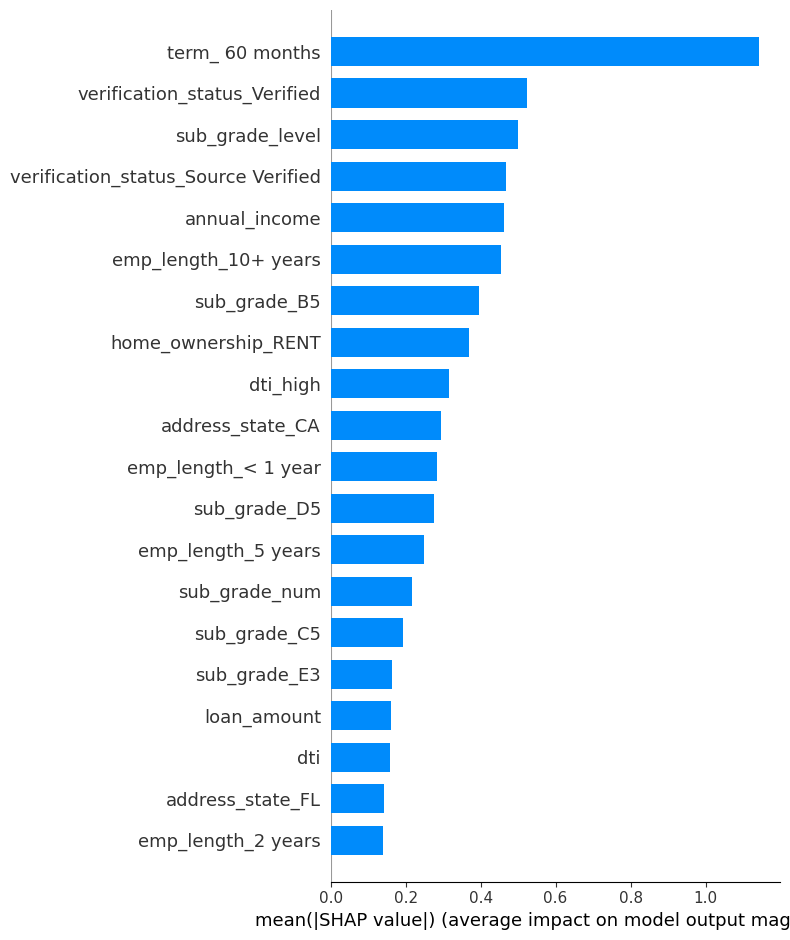

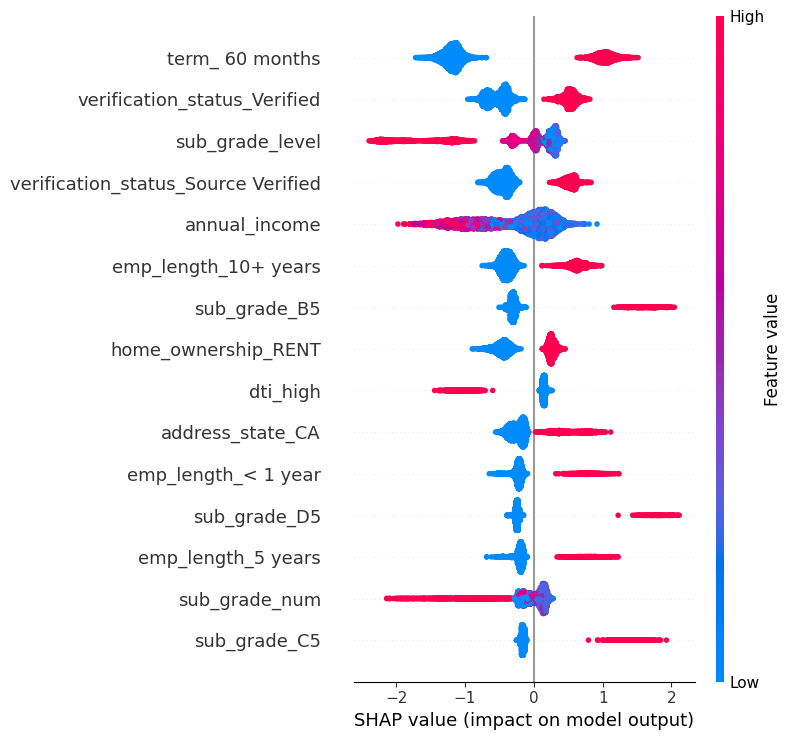

                                 feature  importance
13                       term_ 60 months    1.141530
28          verification_status_Verified    0.524041
12                       sub_grade_level    0.500459
27   verification_status_Source Verified    0.468870
0                          annual_income    0.463308
82                  emp_length_10+ years    0.454045
100                         sub_grade_B5    0.396183
32                   home_ownership_RENT    0.369431
8                               dti_high    0.314290
36                      address_state_CA    0.292987
91                   emp_length_< 1 year    0.283367
110                         sub_grade_D5    0.274663
86                    emp_length_5 years    0.249713
11                         sub_grade_num    0.215621
105                         sub_grade_C5    0.193788
113                         sub_grade_E3    0.163303
3                            loan_amount    0.159509
1                                    dti    0.

In [135]:

shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=20)

shap.summary_plot(shap_values, X_val, max_display=15)

feature_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': np.abs(shap_values).mean(0)
}).sort_values('importance', ascending=False)
print(feature_importance.head(20))